In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [123]:
T = 144
step=1
time = np.arange(0, T, step)
values = np.random.randn(int(T/step))*100
noise = np.random.randn(int(T/step))*1

big_event = np.zeros(int(T/step))
big_event[10:20] = np.arange(10)*100

In [121]:
def plot_time_series(time, values, label):
    plt.figure(figsize=(10,6))
    plt.plot(time, values)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.title(label, fontsize=20)
    plt.grid(True)

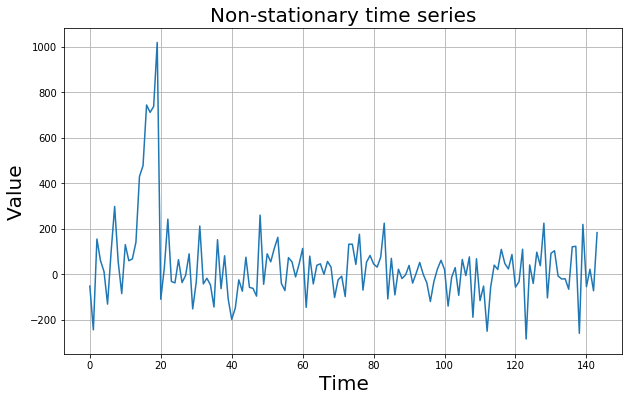

In [114]:
non_stationary = values + big_event
plot_time_series(time, non_stationary, label='Non-stationary time series')

In [13]:
np.random.uniform(5)

4.583085687958951

In [45]:
hej=pd.read_csv('../metadata/video_lengths.csv')[:51]

In [46]:
hej

,Unnamed: 0,subject,video_id,length
0,0,4,4_1a,202
1,1,1,1_2b,93
2,2,6,6_2a,199
3,3,4,4_2a,202
4,4,1,1_1a_3,195
5,5,5,5_1b,157
6,6,1,1_2a,266
7,7,6,6_2b,155
8,8,1,1_1b,97
9,9,2,2_2a,266


In [51]:
lengths = pd.read_csv('../metadata/video_lengths.csv')[51:]
print(lengths['length'].mean())
print(lengths['length'].std())

mu = lengths['length'].mean()
sigma = lengths['length'].std()
print(sigma * np.random.randn(1) + mu)

62.11
14.516375288451023
[93.98810438]


In [2]:
def get_data(nb_series, min_events, max_events, max_event_length, max_intensity, base, T):
    series = []
    series_lengths = []
    lengths = pd.read_csv('../metadata/video_lengths.csv')[51:]
    mu = lengths['length'].mean()
    sigma = lengths['length'].std()

    for i in range(nb_series):
        length_draw = sigma * np.random.randn(1) + mu
        series_lengths.append(length_draw)
        
        values = np.random.randn(int(T))*base
        values = abs(values)
        nb_events = np.random.randint(min_events, max_events)
        for ev in range(nb_events):
            length = np.random.randint(1, max_event_length+1)
            last_valid_start = length_draw - max_event_length
            start = np.random.randint(int(last_valid_start))
            end = start + length
            event = np.zeros(int(T))
            event[start:end] = values[range(start, end, 1)]*max_intensity
            values += event
        values /= sum(values)
        series.append(values)
    return series, series_lengths

In [54]:
values[0]

array([1.79969863e-04, 3.39096727e-04, 6.50682504e-04, 7.36122899e-05,
       5.68009622e-04, 3.92256662e-04, 3.22784347e-05, 3.39688215e-04,
       5.59176705e-04, 6.95510414e-04, 1.03874737e-04, 1.81586525e-04,
       1.35306690e-04, 1.52446120e-04, 2.59385515e-04, 1.45857766e-04,
       4.44923934e-04, 2.89331243e-04, 9.47303953e-04, 9.33008831e-05,
       1.56480040e-04, 8.43372661e-05, 1.58200036e-04, 5.43634835e-04,
       8.01550995e-05, 1.40941494e-01, 7.99788645e-05, 5.34647644e-04,
       4.80090861e-05, 3.75307776e-04, 5.03787827e-02, 4.25099618e-03,
       3.27366131e-04, 9.53897809e-04, 8.95910814e-05, 7.64966269e-05,
       4.17082068e-03, 2.28862537e-02, 2.90890944e-04, 9.00981604e-05,
       3.43145438e-04, 5.90634404e-04, 1.68516370e-04, 1.57601594e-04,
       2.48762042e-05, 3.76091735e-04, 4.78118880e-04, 1.49413220e-04,
       5.59069316e-04, 3.99135454e-04, 3.30682924e-04, 3.82009092e-04,
       3.87892485e-04, 6.26991720e-04, 1.85365060e-04, 4.55715310e-04,
      

In [55]:
values[0][range(1,3,1)]

array([0.0003391 , 0.00065068])

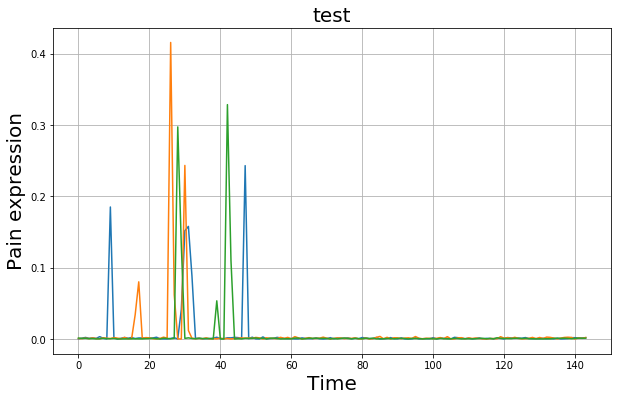

In [128]:
values, lengths = get_data(3, 1, 12, 2, 200, 1, 144)
plot_many_time_series(time, values, label='test')

In [32]:
nb_pain = 1
nb_nopain = 1

base = 10

pain, pain_lengths = get_data(nb_pain, min_events=3, max_events=12, max_event_length=2, max_intensity=10, base=base, T=100)

nopain, nopain_lengths = get_data(nb_nopain, min_events=1, max_events=5, max_event_length=2, max_intensity=8, base=base, T=100)



In [60]:
pain[0].shape

(144,)

In [66]:
def plot_many_time_series(time, values, title, labels):
    plt.figure(figsize=(10,6))
    for ind, v in enumerate(values):
        plt.plot(time, v, label='{}'.format(labels[ind]))
    plt.xlabel("t (s)", fontsize=20)
    plt.ylabel("Pain expression", fontsize=20)
    plt.title(title, fontsize=30)
    plt.legend(fontsize=20)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 5.5)
    fig.savefig('test2png.png', dpi=100)
    # plt.rcParams["figure.figsize"] = (30,2)
    plt.grid(True)
    
    plt.savefig('sparsepain.png')

2
(100,)


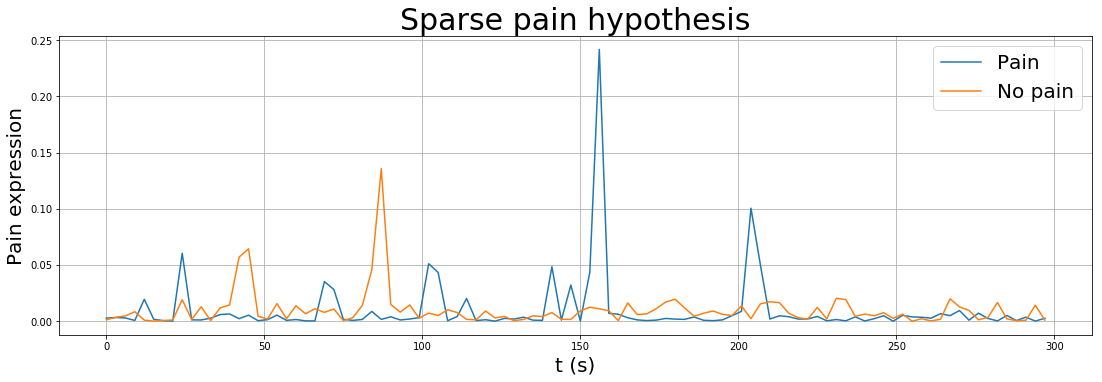

In [69]:
nb_pain = 1
nb_nopain = 1

base = 10

# pain, pain_lengths = get_data(nb_pain, min_events=3, max_events=12, max_event_length=2, max_intensity=10, base=base, T=100)

# nopain, nopain_lengths = get_data(nb_nopain, min_events=1, max_events=5, max_event_length=2, max_intensity=8, base=base, T=100)




# plot_data = pain + nopain
T = 300
step=3
time = np.arange(0, T, step)
print(len(plot_data))
print(plot_data[0].shape)
labels = ['Pain', 'No pain']
plot_many_time_series(time, plot_data, title='Sparse pain hypothesis', labels=labels)

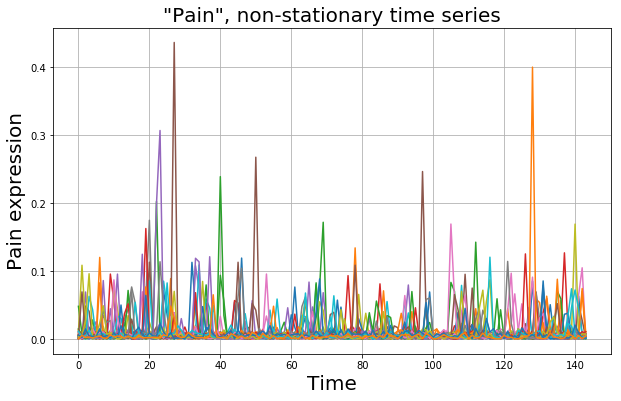

In [9]:
plot_many_time_series(time, pain, label='"Pain", non-stationary time series')

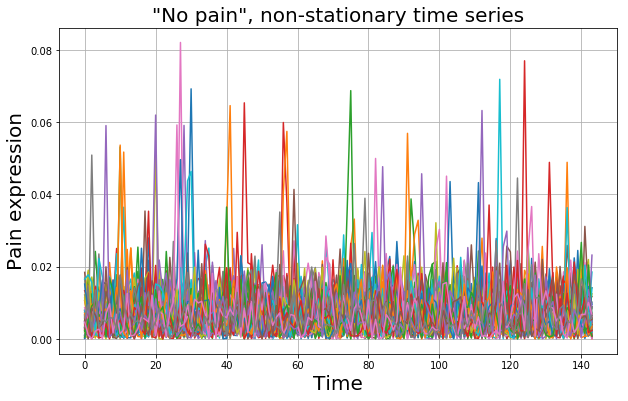

In [10]:
plot_many_time_series(time, nopain, label='"No pain", non-stationary time series')

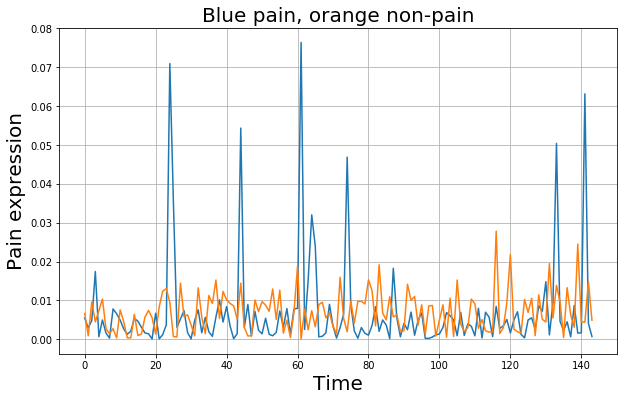

In [11]:
plot_many_time_series(time, [pain[0], nopain[0]], label='Blue pain, orange non-pain')

In [66]:
pain[0].shape

(144,)

In [67]:
nopain[0].shape

(144,)

In [70]:
data = pain + nopain

In [71]:
len(data)

100

In [75]:
labels = [np.zeros(42).tolist() + np.ones(58).tolist()]

In [80]:
labels[0][:3]

[0.0, 0.0, 0.0]

In [85]:
data[0][:3]

array([ 7.47905966,  8.35700889, 13.50528935])

In [87]:
data = [x.astype(np.float32) for x in data]

In [81]:
labels = [int(x) for x in labels[0]]

In [130]:
def gen(nb_samples, lengths, data, labels):
    data = [x.astype(np.float32) for x in data]
    labels = [int(x) for x in labels[0]]
    lengths = [int(x) for x in lengths]
    for i in range(nb_samples):
        x = data[i]
        label = labels[i]
        length = lengths[i]
        if label == 0:
            label = [1, 0]
        if label == 1:
            label = [0, 1]
        yield x, label, length

In [131]:
def construct_dataset(nb_pain, nb_nopain, T, base_level,
                      max_intensity_pain, max_intensity_nopain,
                      max_length_pain, max_length_nopain,
                      min_events_pain, nb_events_pain, min_events_nopain, nb_events_nopain, batch_size):

    pain, p_lengths = get_data(nb_pain, min_events=min_events_pain, max_events=nb_events_pain, max_event_length=max_length_pain,
                    max_intensity=max_intensity_pain, base=base_level, T=T)
    nopain, np_lengths = get_data(nb_nopain, min_events=min_events_nopain, max_events=nb_events_nopain, max_event_length=max_length_nopain,
                      max_intensity=max_intensity_nopain, base=base_level, T=T)
    data = nopain + pain
    labels = [np.zeros(nb_nopain).tolist() + np.ones(nb_pain).tolist()]
    dataset = tf.data.Dataset.from_generator(lambda: gen(nb_pain+nb_nopain, np_lengths + p_lengths, data, labels), output_types=(tf.float32,tf.int32, tf.int32))
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [136]:
np.random.randint(50,80)

61

In [132]:
import sys
sys.path.append('..')

def get_sparse_pain_loss(y_batch, preds_batch):
    batch_size = y_batch.shape[0]  # last batch may be smaller

    def get_mil_loss(kmax_scores):
        kmax_distribution = tf.keras.layers.Activation('softmax')(kmax_scores)
        mils = 0
        for sample_index in range(batch_size):
            label_index = tf.argmax(y_batch[sample_index, :])  # Take first (video-level label)
            mil = tf.math.log(kmax_distribution[sample_index, label_index])
            mils += mil
        return mils

    kmax_scores = get_k_max_scores_per_class(y_batch, preds_batch, batch_size)
    mil = get_mil_loss(kmax_scores)
    batch_indicator_nopain = tf.cast(y_batch[:, 0], dtype=tf.float32)
    batch_indicator_pain = tf.cast(y_batch[:, 1], dtype=tf.float32)
    tv_nopain = config_dict['tv_weight_nopain'] * tf.reduce_sum(
        batch_indicator_nopain * batch_calc_TV_norm(preds_batch[:, 0],
                                                    y_batch))
    tv_pain = config_dict['tv_weight_pain'] * tf.reduce_sum(
        batch_indicator_pain * batch_calc_TV_norm(preds_batch[:, 1],
                                                  y_batch))
    total_loss = tv_nopain + tv_pain - mil
                                                                                                                                                        
    return total_loss, tv_pain, tv_nopain, mil

def get_k_max_scores_per_class(y_batch, preds_batch, batch_size):                                                           
    kmax_scores = []
    for sample_index in range(batch_size):
        sample_class_kmax_scores = []
        seq_length = 144
        k = tf.cast(tf.math.ceil(config_dict['k_mil_fraction'] * tf.cast(seq_length, dtype=tf.float32)), dtype=tf.int32)
        # print('\n', k, seq_length)
        for class_index in range(config_dict['nb_labels']):
            preds_nopad = preds_batch[sample_index, :, class_index]
            k_preds, indices = tf.math.top_k(preds_nopad, k)
            sample_class_kmax_score = tf.cast(1/k, dtype=tf.float32) * tf.reduce_sum(k_preds)
            sample_class_kmax_scores.append(sample_class_kmax_score)
        kmax_scores.append(sample_class_kmax_scores)
    kmax_scores = tf.convert_to_tensor(kmax_scores)
    return kmax_scores


def batch_calc_TV_norm(batch_vectors, y_batch, p=3, q=3):
    """"
    Calculates the Total Variational Norm by summing the differences of the values
    in between the different positions in the mask.
    p=3 and q=3 are defaults from the paper.
    """
    val = tf.cast(0, dtype=tf.float32)
    batch_size = batch_vectors.shape[0]
    batch_length = batch_vectors.shape[1]
    vals = tf.TensorArray(tf.float32, size=batch_size)
    for vector_index in range(batch_size):
        vector = batch_vectors[vector_index]
        for u in range(1, batch_length - 1):
            val += tf.abs(vector[u - 1] - vector[u]) ** p
            val += tf.abs(vector[u + 1] - vector[u]) ** p
        val = val ** (1 / p)
        val = val ** q
        vals = vals.write(vector_index, val)
    return vals.stack()

def evaluate_sparse_pain(y_batch, preds_batch):
    batch_size = y_batch.shape[0]
    kmax_scores = get_k_max_scores_per_class(y_batch, preds_batch, batch_size)
    batch_class_distribution = tf.keras.layers.Activation('softmax')(kmax_scores)
    return batch_class_distribution

def get_gru_model():
    input_features = tf.keras.layers.Input(shape=(144, 1))
    feature_enc1 = tf.keras.layers.GRU(32, return_sequences=True)
    feature_enc2 = tf.keras.layers.GRU(2, return_sequences=True)
    #feature_enc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))
    x = feature_enc1(input_features)
    x = feature_enc2(x)
    model = tf.keras.Model(inputs=[input_features], outputs=[x]) 
    model.summary()
    return model

def get_dense_model():
    input_features = tf.keras.layers.Input(shape=(144))
    feature_enc1 = tf.keras.layers.Dense(32)
    feature_enc2 = tf.keras.layers.Dense(2)
    #feature_enc = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))
    x = feature_enc1(input_features)
    x = feature_enc2(x)
    model = tf.keras.Model(inputs=[input_features], outputs=[x]) 
    model.summary()
    return model

def mask_out_padding_predictions(preds_batch, length, batch_size, pad_length, one):                                                                                                                                                      
    zeros = tf.zeros_like(preds_batch)

    mask_tensor = tf.TensorArray(tf.float32, size=batch_size)

    if one is None:  # Cannot recreate tf.Variables in each step.
        one = tf.Variable(tf.ones([pad_length, 1]))

    for u in range(batch_size):
        one.assign(tf.ones([pad_length, 1]))
        indices = tf.where([(i >= length[u]) for i in range(pad_length)])
        # Put zeros in the mask where the sum of the y-labels is 0
        hej = tf.gather(zeros[0,:,0], indices)
        mask = tf.compat.v1.scatter_nd_update(one, indices, hej)
        # Need mask for both classes: (pad_length x nb_labels)
        masks = tf.stack([mask, mask], axis=1)
        mask_tensor = mask_tensor.write(u, masks)
    mask_tensor = mask_tensor.stack()
    mask_tensor = tf.reshape(mask_tensor, preds_batch.shape)
    preds_batch = tf.keras.layers.multiply([preds_batch, mask_tensor])
    return preds_batch

In [133]:
import wandb
wandb.init(project="1d-pain")

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/Midgard/home/sbroome/miniconda3/envs/pfr/lib/python3.6/site-packages/wandb/sdk/wandb_run.py", line 1215, in _atexit_cleanup
    self._on_finish()
  File "/Midgard/home/sbroome/miniconda3/envs/pfr/lib/python3.6/site-packages/wandb/sdk/wandb_run.py", line 1363, in _on_finish
    self._backend.interface.publish_exit(self._exit_code)
  File "/Midgard/home/sbroome/miniconda3/envs/pfr/lib/python3.6/site-packages/wandb/sdk/interface/interface.py", line 590, in publish_exit
    self._publish(rec)
  File "/Midgard/home/sbroome/miniconda3/envs/pfr/lib/python3.6/site-packages/wandb/sdk/interface/interface.py", line 439, in _publish
    raise Exception("The wandb backend process has shutdown")
Exception: The wandb backend process has shutdown


In [134]:
config_dict = {'k_mil_fraction': 0.05,
              'tv_weight_nopain': 1,
              'tv_weight_pain': 0.01,
              'nb_labels': 2,
              'lr': 0.00001,
              'epochs': 500}

# model = get_dense_model()
model = get_gru_model()
loss_fn = tf.keras.losses.BinaryCrossentropy()
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     config_dict['lr'],
#     decay_steps=40,
#     decay_rate=0.96,
#     staircase=True)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=config_dict['lr'])

def train_step(x, y, length, one):
    with tf.GradientTape() as tape:
        preds_seq = model(x)
        # print(y.shape, preds_seq.shape)
        preds_seq = mask_out_padding_predictions(preds_seq, length, batch_size, T, one)
        
        sparse_loss, tv_p, tv_np, mil = get_sparse_pain_loss(y, preds_seq)
        preds_mil = evaluate_sparse_pain(y, preds_seq)
        loss = sparse_loss
        # loss = loss_fn(y, preds_seq)
    
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, preds_mil)
    # train_acc_metric.update_state(y, preds_seq)
    return loss
    
def val_step(x, y, length, one):
    preds_seq = model(x)
    preds_seq = mask_out_padding_predictions(preds_seq, length, val_batch_size, T, one)
    sparse_loss, tv_p, tv_np, mil = get_sparse_pain_loss(y, preds_seq)
    preds_mil = evaluate_sparse_pain(y, preds_seq)
    loss = sparse_loss
    val_acc_metric.update_state(y, preds_mil)
#     loss = loss_fn(y, preds_seq)
#     val_acc_metric.update_state(y, preds_seq)
    return loss


T=144
base_level = 1
max_intensity_pain = 2000
max_intensity_nopain = 1
max_length_pain = 2
max_length_nopain = 2
min_events_pain = 5
nb_events_pain = 50
min_events_nopain = 0
nb_events_nopain = 3
batch_size = 20
val_batch_size = 1

one = None

train_dataset = construct_dataset(nb_pain=36, nb_nopain=51, T=T, base_level=base_level,
                      max_intensity_pain=max_intensity_pain, max_intensity_nopain=max_intensity_nopain,
                      max_length_pain=max_length_pain, max_length_nopain=max_length_nopain,
                      min_events_pain=min_events_pain,nb_events_pain=nb_events_pain,min_events_nopain=min_events_nopain,
                      nb_events_nopain=nb_events_nopain, batch_size=batch_size)

val_dataset = construct_dataset(nb_pain=6, nb_nopain=7, T=T, base_level=base_level,
                      max_intensity_pain=max_intensity_pain, max_intensity_nopain=max_intensity_nopain,
                      max_length_pain=max_length_pain, max_length_nopain=max_length_nopain,
                      min_events_pain=min_events_pain, nb_events_pain=nb_events_pain,
                      min_events_nopain=min_events_nopain, nb_events_nopain=nb_events_nopain, batch_size=val_batch_size)

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

for epoch in range(config_dict['epochs']):
    for x, y, length in train_dataset:
        train_loss = train_step(x, y, length, one)
        wandb.log({'train_loss': train_loss})
    train_acc = train_acc_metric.result()
    wandb.log({'train_acc': train_acc})
    
        
    for x, y, length in val_dataset:
        val_loss = val_step(x, y, length, one)
        wandb.log({'val_loss': val_loss})
    val_acc = val_acc_metric.result()
    wandb.log({'val_acc': val_acc})
    if epoch % 20 == 0:
        print('Training acc over epoch %d: %.4f' % (epoch, float(train_acc),))
        print("Validation acc: %.4f" % (float(val_acc),))

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 144, 1)]          0         
_________________________________________________________________
gru_68 (GRU)                 (None, 144, 32)           3360      
_________________________________________________________________
gru_69 (GRU)                 (None, 144, 2)            216       
Total params: 3,576
Trainable params: 3,576
Non-trainable params: 0
_________________________________________________________________
Training acc over epoch 0: 0.5875
Validation acc: 0.5385


KeyboardInterrupt: 